## <a name="p10">TWITTER SENTIMENT ANALYSIS </a>


In [3]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import nltk 
nltk.download('wordnet')
nltk.download('omw-1.4')

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


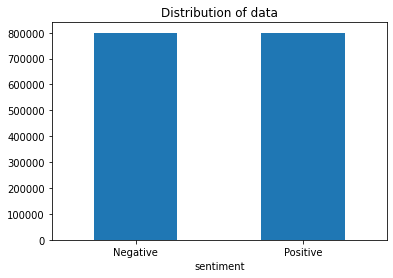

In [4]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(r"D:\ekas\THAPAR\ML\project\training.1600000.processed.noemoticon.csv",
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

dataset = dataset[['sentiment','text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

text = list(dataset['text'])
sentiment = list(dataset['sentiment'])

In [5]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [6]:
def preprocess(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwordlist:
                if len(word)>1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [7]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 160 seconds


### Word-Cloud for Negative tweets.

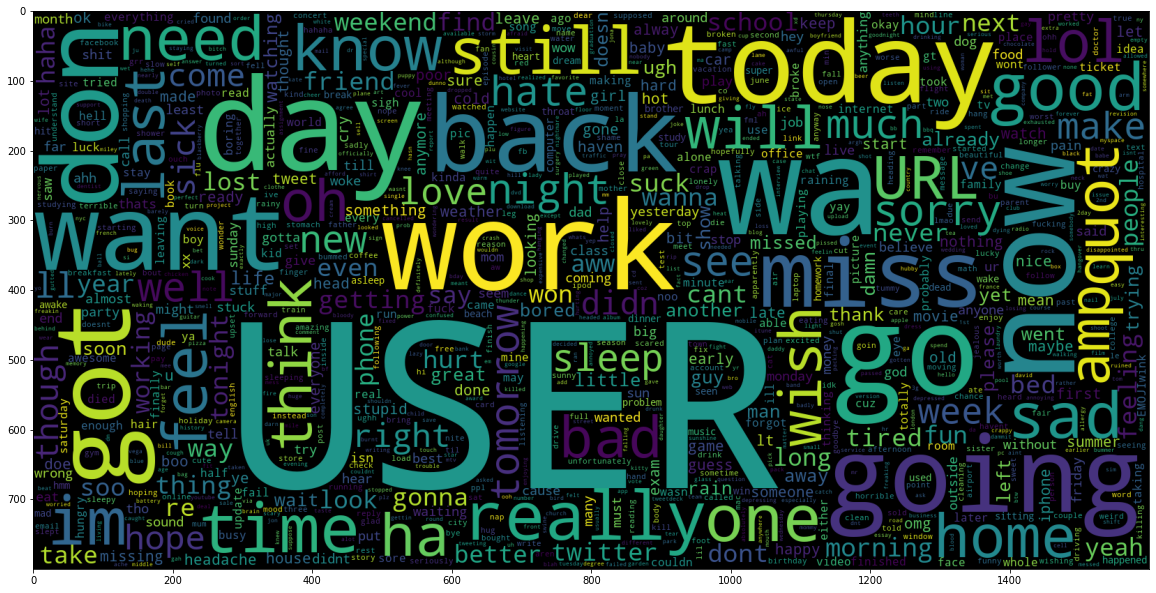

In [8]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud for Positive tweets.

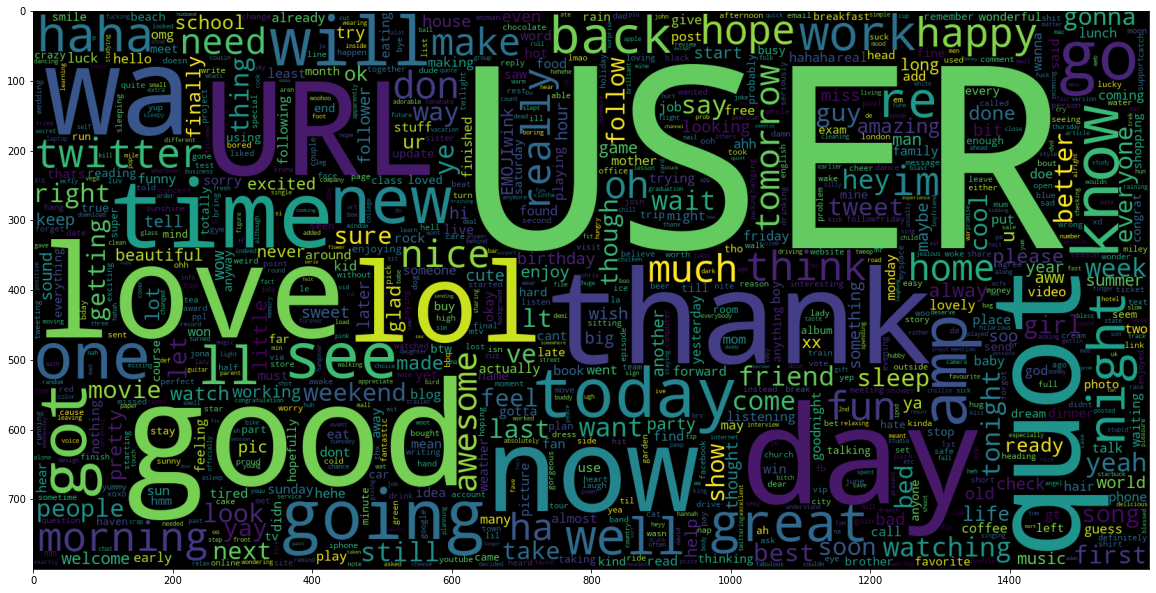

In [9]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [11]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


c:\Users\ekasp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [12]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


### Evaluate Model Function

In [13]:
def model_Evaluate(model):
    
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



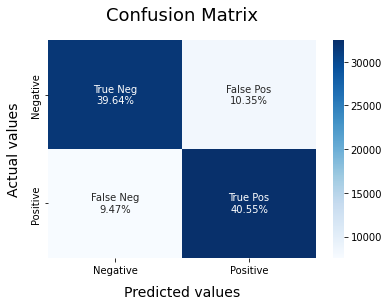

In [14]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



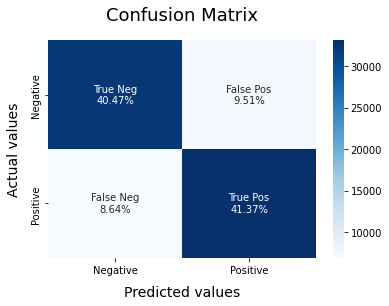

In [15]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



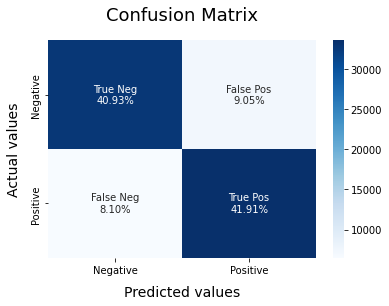

In [16]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

### <a name="p8-3">ANN Model</a>

In [17]:
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(processedtext)
sequences = tok.texts_to_sequences(processedtext)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [18]:
sequences_matrix.shape
y2 = dataset.sentiment
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(sequences_matrix, y2, test_size=0.3, random_state=2)

In [19]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model 

In [20]:
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [21]:
history=model.fit(np.array(X_train2), np.array(Y_train2),batch_size=1000,epochs=1) 
print('Training fi-nished !!')

1120/1120 [==============================] - 13058s 12s/step - loss: 0.4681 - accuracy: 0.7780
Training fi-nished !!


In [22]:
accr1 = model.evaluate(X_test2,Y_test2)

15000/15000 [==============================] - 800s 53ms/step - loss: 0.4388 - accuracy: 0.7939


In [23]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) 

Test set
  Accuracy: 0.79


In [24]:
y_pred2 = model.predict(X_test2) 
y_pred2 = (y_pred2 > 0.5) 


15000/15000 [==============================] - 969s 65ms/step


              precision    recall  f1-score   support

           0       0.79      0.81      0.80    239722
           1       0.80      0.78      0.79    240278

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000



Text(0.5, 1.0, 'Confusion Matrix')

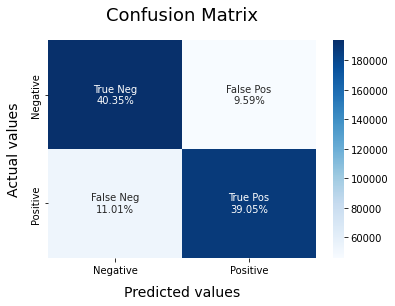

In [25]:
print(classification_report(Y_test2, y_pred2))

cf_matrix = confusion_matrix(Y_test2, y_pred2)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## <a name="p9">Saving the Models</a>
We're using **PICKLE** to save **Vectoriser and BernoulliNB, Logistic Regression Model,ANN** for later use.

In [26]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-ANN.pickle','wb')
pickle.dump(model, file)
file.close()

INFO:tensorflow:Assets written to: ram://d44bb982-b7dc-4104-bd8a-c67df8cc9a69/assets


INFO:tensorflow:Assets written to: ram://d44bb982-b7dc-4104-bd8a-c67df8cc9a69/assets


## <a name="p10">Using the Model.</a>



In [50]:

'''
def load_models():
    # Load the vectoriser.
    file = open("D:/ekas/THAPAR/ML/project/vectoriser-ngram-(1,2).pickle", 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open("D:\ekas\THAPAR\ML\project\Sentiment-LR.pickle", 'rb')
    LRmodel = pickle.load(file)
    file.close()

    file = open("D:\ekas\THAPAR\ML\project\Sentiment-SVC.pickle", 'rb')
    SVCmodel = pickle.load(file)
    file.close()

    file = open("D:\ekas\THAPAR\ML\project\Sentiment-BNB.pickle", 'rb')
    BNBmodel = pickle.load(file)
    file.close()

    file = open("D:\ekas\THAPAR\ML\project\Sentiment-ANN.pickle", 'rb')
    model = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel,SVCmodel,BNBmodel,model
'''

def predict(vectoriser, model, text):
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    #df = df.replace([0,1], ["Negative","Positive"])
    return df

    

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel,SVCmodel,BNBmodel,model = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Thankyou for this gift",
            "Mr. Stark, I am unsure",
            "This semester is very boring"]
    
    df1 = predict(vectoriser, LRmodel, text)
    df2 = predict(vectoriser, SVCmodel, text)
    df3 = predict(vectoriser, BNBmodel, text)

    print(df1)

    print(df2.head())

    print(df3.head())

    test_text = tok.texts_to_sequences(text)
    sequences_matrix_test = sequence.pad_sequences(test_text,maxlen=max_len)
    y_predict = model.predict(sequences_matrix_test) #getting predictions on the trained model
    y_predict = (y_predict > 0.5)
    d = y_predict
    d= d.astype(int)
    df4=pd.DataFrame(text)
    df4[1]=d
    df4.columns=('text','sentiment')
    print(df4)

                           text  sentiment
0                I hate twitter          0
1    May the Force be with you.          1
2        Thankyou for this gift          1
3        Mr. Stark, I am unsure          1
4  This semester is very boring          0
                           text  sentiment
0                I hate twitter          0
1    May the Force be with you.          1
2        Thankyou for this gift          1
3        Mr. Stark, I am unsure          1
4  This semester is very boring          0
                           text  sentiment
0                I hate twitter          0
1    May the Force be with you.          1
2        Thankyou for this gift          1
3        Mr. Stark, I am unsure          1
4  This semester is very boring          0
1/1 [==============================] - 0s 185ms/step
                           text  sentiment
0                I hate twitter          0
1    May the Force be with you.          1
2        Thankyou for this gift          1
3

## <a name="p10">ENSEMBLE MODEL.</a>


In [41]:
# make a prediction with a hard voting ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
# define dataset
# X_train, y_train
# define the base models
models = list()
models.append(('LR', LRmodel))
models.append(('SVC', SVCmodel))
models.append(('Bernoulli', BNBmodel ))

ensemble = VotingClassifier(estimators=models, voting='hard')
ensemble.fit(X_train, y_train)
yhat = ensemble.predict(X_test)


In [42]:
print(yhat)

[0 0 0 ... 0 1 1]


              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.83      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



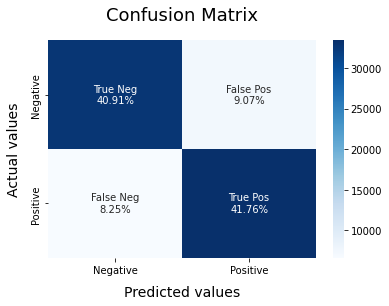

In [43]:
model_Evaluate(ensemble)